# Model predicts the transaction is fraud or not

# Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,TargetEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,root_mean_squared_error,r2_score
from tabulate import tabulate
import joblib
import plotly.express as px
from sklearn.linear_model import Ridge,Lasso
from sklearn.svm import SVC
from sklearn.model_selection import KFold,cross_val_score,train_test_split
import matplotlib.pyplot as plt
import numpy as np
import shap
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

/Users/abduroshyd/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data information


In [2]:
df=pd.read_csv('/Users/abduroshyd/Downloads/transactions.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

# Dropping non-usuful features

In [4]:
df.drop('transaction_id',axis=1, inplace=True)


In [5]:
df.drop('user_id',axis=1,inplace=True)

In [6]:
# Bu datasetda model `is_fraud` ni predict qiladi
#
# is_fraud:
# 0 — oddiy (halol) tranzaksiya
# 1 — firibgarlik (fraud) tranzaksiya
#
# Model quyidagi 16 ta feature asosida qaror chiqaradi:
# - foydalanuvchi profili:
#   account_age_days, total_transactions_user, avg_amount_user
# - tranzaksiya summasi:
#   amount
# - geografiya:
#   country, bin_country, shipping_distance_km
# - tranzaksiya kanali va merchant turi:
#   channel, merchant_category
# - xavfsizlik tekshiruvlari:
#   avs_match, cvv_result, three_ds_flag
# - promo ishlatilganligi:
#   promo_used
# - tranzaksiya vaqti:
#   transaction_time
#
# Modelning vazifasi:
# "Bu tranzaksiya fraudmi yoki yo‘qmi?" degan savolga javob berish


In [7]:
df.head()

,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


In [8]:
df.isnull().sum()

account_age_days           0
total_transactions_user    0
avg_amount_user            0
amount                     0
country                    0
bin_country                0
channel                    0
merchant_category          0
promo_used                 0
avs_match                  0
cvv_result                 0
three_ds_flag              0
transaction_time           0
shipping_distance_km       0
is_fraud                   0
dtype: int64

In [9]:
import os
folder="data"
filename="df_row.csv"
os.makedirs(folder,exist_ok=True)
file_path=os.path.join(folder,filename)
df.to_csv(file_path,index=False)

# Train test split

In [10]:
x=df.drop('is_fraud',axis=1)
y=df['is_fraud']
x_test,x_train,y_test,y_train=train_test_split(x,y,test_size=0.2,random_state=42)
# df divided x_test,x_train y_test,y_train

In [11]:
x_train.head()

,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km
52459,545,60,116.82,139.13,PL,PL,app,gaming,1,0,0,0,2024-02-14T19:21:31Z,266.81
155258,1480,58,115.75,69.41,IT,GB,web,fashion,0,1,1,1,2024-02-03T16:41:49Z,1205.96
296928,695,48,147.36,163.71,FR,FR,app,fashion,0,1,1,1,2024-03-03T18:53:07Z,187.87
204506,571,55,163.28,290.11,PL,PL,web,travel,1,1,1,0,2024-01-02T05:09:12Z,288.42
18604,202,46,234.93,497.32,TR,TR,web,grocery,0,1,1,1,2024-06-25T00:51:34Z,212.11


In [12]:
x_test.head()

,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km
182583,1297,59,62.80,66.56,DE,DE,web,travel,0,1,1,1,2024-06-14T15:08:57Z,218.20
106870,1319,42,20.75,15.00,ES,ES,web,grocery,0,1,1,0,2024-03-17T12:55:28Z,99.31
225734,1361,58,716.99,344.49,NL,NL,app,fashion,0,0,1,1,2024-05-31T10:29:53Z,119.64
229712,760,53,461.77,528.46,PL,PL,app,grocery,0,1,1,1,2024-07-22T18:26:38Z,388.92
13696,204,51,109.84,150.57,FR,FR,app,electronics,0,1,1,1,2024-05-01T23:17:55Z,294.53


# Baseline

# Handling missing values

In [13]:
def fillna_mean_mode(x_train, x_test):
    x_train = x_train.copy()
    x_test = x_test.copy()

    for col in x_train.columns:
        if x_train[col].dtype in [ "float64"]:
            fill_value = x_train[col].mean()
        else:
            fill_value = x_train[col].mode()[0]
        x_train[col] = x_train[col].fillna(fill_value)
        x_test[col] = x_test[col].fillna(fill_value)

    return x_train, x_test
# missing values filled with mean  and mode 

In [14]:

x_train_filled, x_test_filled = fillna_mean_mode(x_train, x_test)
# function getting runned

# Encoding 

In [15]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def encode_train(df, threshold=5):
    df = df.copy()
    encoders = {}

    for col in df.columns:
        if df[col].dtype == 'object':
            if df[col].nunique() <= threshold:
                # One-hot encoding
                dummies = pd.get_dummies(df[col], prefix=col, dtype=int)
                df = pd.concat([df.drop(columns=col), dummies], axis=1)
            else:
                # Label encoding
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col])
                encoders[col] = le

    return df, encoders

In [16]:
def encode_test(df, encoders, train_columns):
    df = df.copy()

    for col, le in encoders.items():
        df[col] = df[col].astype(str)
        encoded = []
        for val in df[col]:
            if val in le.classes_:
                encoded.append(le.transform([val])[0])
            else:
                encoded.append(-1)  
        df[col] = encoded

    df = pd.get_dummies(df)
    df = df.reindex(columns=train_columns, fill_value=0)

    return df
# x_test encoded with onhot and label encoders

# Running encoding

In [17]:

x_train_encoded, encoders = encode_train(x_train_filled)
x_test_encoded = encode_test(x_test_filled, encoders, x_train_encoded.columns)
# encoding function getting runned

In [18]:
x_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59939 entries, 52459 to 42950
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_age_days               59939 non-null  int64  
 1   total_transactions_user        59939 non-null  int64  
 2   avg_amount_user                59939 non-null  float64
 3   amount                         59939 non-null  float64
 4   country                        59939 non-null  int64  
 5   bin_country                    59939 non-null  int64  
 6   promo_used                     59939 non-null  int64  
 7   avs_match                      59939 non-null  int64  
 8   cvv_result                     59939 non-null  int64  
 9   three_ds_flag                  59939 non-null  int64  
 10  transaction_time               59939 non-null  int64  
 11  shipping_distance_km           59939 non-null  float64
 12  channel_app                    59939 non-null  

In [19]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59939 entries, 52459 to 42950
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account_age_days         59939 non-null  int64  
 1   total_transactions_user  59939 non-null  int64  
 2   avg_amount_user          59939 non-null  float64
 3   amount                   59939 non-null  float64
 4   country                  59939 non-null  object 
 5   bin_country              59939 non-null  object 
 6   channel                  59939 non-null  object 
 7   merchant_category        59939 non-null  object 
 8   promo_used               59939 non-null  int64  
 9   avs_match                59939 non-null  int64  
 10  cvv_result               59939 non-null  int64  
 11  three_ds_flag            59939 non-null  int64  
 12  transaction_time         59939 non-null  object 
 13  shipping_distance_km     59939 non-null  float64
dtypes: float64(3), int64(6)

# Scaling

In [20]:
from sklearn.preprocessing import MinMaxScaler

def scale_train(df):
    df = df.copy()
    scalers = {}

    for col in df.columns:
        if df[col].dtype != 'object':
            scaler = MinMaxScaler()
            df[col] = scaler.fit_transform(df[[col]])
            scalers[col] = scaler

    return df, scalers
# scaling for x_train with Minmax scaler

In [21]:
def scale_test(df, scalers):
    df = df.copy()

    for col in df.columns:
        if col in scalers:
            df[col] = scalers[col].transform(df[[col]])

    return df
# scaling for x_test 

# Running scaling

In [22]:
x_train_scaled, scalers = scale_train(x_train_encoded)
x_test_scaled = scale_test(x_test_encoded, scalers)
# scaling function gettting runned

In [23]:
import os
folder="data"
filename="baseline_preprocessed.csv"
os.makedirs(folder,exist_ok=True)
file_path=os.path.join(folder,filename)
df.to_csv(file_path,index=False)

In [24]:
x_train_scaled.head()

,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,channel_app,channel_web,merchant_category_electronics,merchant_category_fashion,merchant_category_gaming,merchant_category_grocery,merchant_category_travel
52459,0.287983,1.00,0.024837,0.008135,0.666667,0.666667,1.0,0.0,0.0,0.0,0.147890,0.071177,1.0,0.0,0.0,0.0,1.0,0.0,0.0
155258,0.782954,0.90,0.024602,0.004029,0.444444,0.333333,0.0,1.0,1.0,1.0,0.112826,0.321713,0.0,1.0,0.0,1.0,0.0,0.0,0.0
296928,0.367390,0.40,0.031532,0.009583,0.222222,0.222222,0.0,1.0,1.0,1.0,0.207243,0.050118,1.0,0.0,0.0,1.0,0.0,0.0,0.0
204506,0.301747,0.75,0.035021,0.017028,0.666667,0.666667,1.0,1.0,1.0,0.0,0.004293,0.076942,0.0,1.0,0.0,0.0,0.0,0.0,1.0
18604,0.106406,0.30,0.050728,0.029232,0.888889,0.888889,0.0,1.0,1.0,1.0,0.577846,0.056584,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [25]:
x_test_scaled.head()

,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,channel_app,channel_web,merchant_category_electronics,merchant_category_fashion,merchant_category_gaming,merchant_category_grocery,merchant_category_travel
182583,0.686077,0.95,0.012995,0.003861,0.000000,0.000000,0.0,1.0,1.0,1.0,-0.000017,0.058209,0.0,1.0,0.0,0.0,0.0,0.0,1.0
106870,0.697724,0.10,0.003777,0.000825,0.111111,0.111111,0.0,1.0,1.0,0.0,-0.000017,0.026493,0.0,1.0,0.0,0.0,0.0,1.0,0.0
225734,0.719958,0.90,0.156402,0.020230,0.555556,0.555556,0.0,0.0,1.0,1.0,-0.000017,0.031916,1.0,0.0,0.0,1.0,0.0,0.0,0.0
229712,0.401800,0.65,0.100454,0.031066,0.666667,0.666667,0.0,1.0,1.0,1.0,-0.000017,0.103752,1.0,0.0,0.0,0.0,0.0,1.0,0.0
13696,0.107464,0.55,0.023307,0.008809,0.222222,0.222222,0.0,1.0,1.0,1.0,-0.000017,0.078572,1.0,0.0,1.0,0.0,0.0,0.0,0.0


# Training

In [26]:
# training Logistic Regression and Random Forest Classifier
lr= LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(random_state=42)
lr.fit(x_train_encoded, y_train)
rf.fit(x_train_encoded, y_train)

/Users/abduroshyd/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier(random_state=42)

# Shap value Global

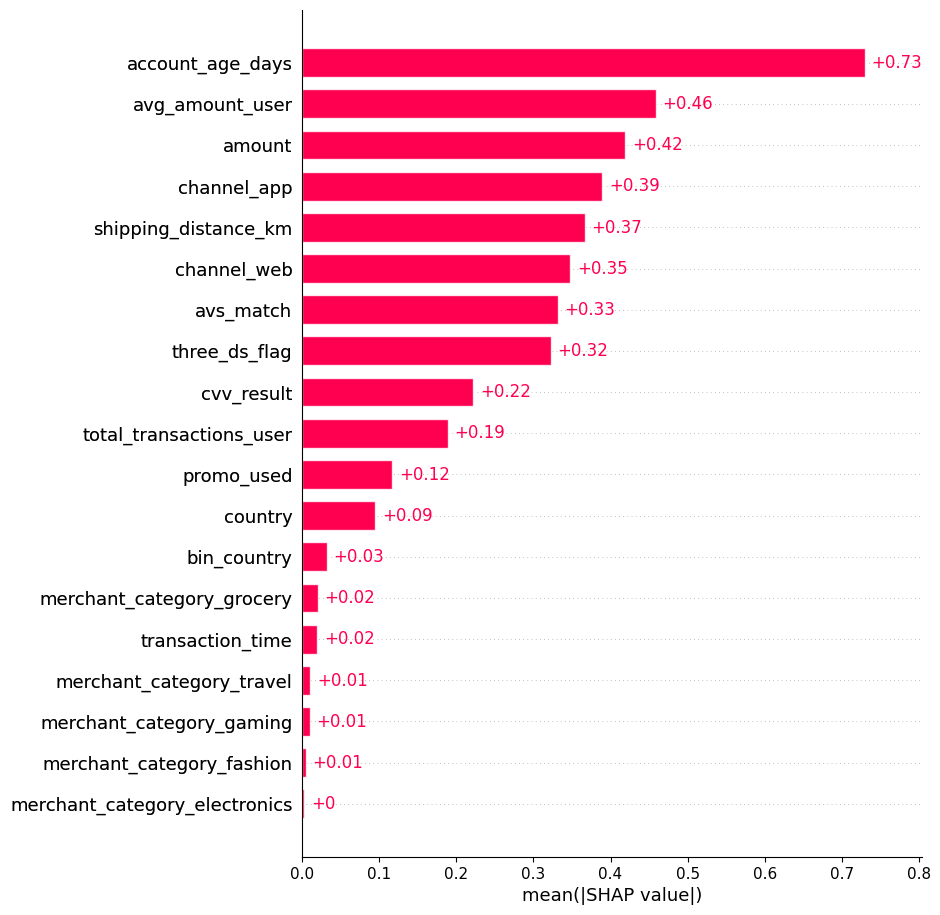

In [27]:
explainer = shap.LinearExplainer(lr, x_train_encoded, feature_names=x_train_encoded.columns.tolist())
# shapmvalue for Linear model
x_sample = x_test_encoded.iloc[:500]
shap_values = explainer(x_sample)
shap.plots.bar(shap_values, max_display=20)
plt.show()
# showing bar with matplotlib

In [28]:
explainer = shap.LinearExplainer(lr, x_train_encoded, feature_names=x_train_encoded.columns.tolist())
# shapmvalue for Linear model

In [ ]:
x_sample = x_test_encoded.iloc[:500]
shap_values = explainer(x_sample)
# 500 sample dataset

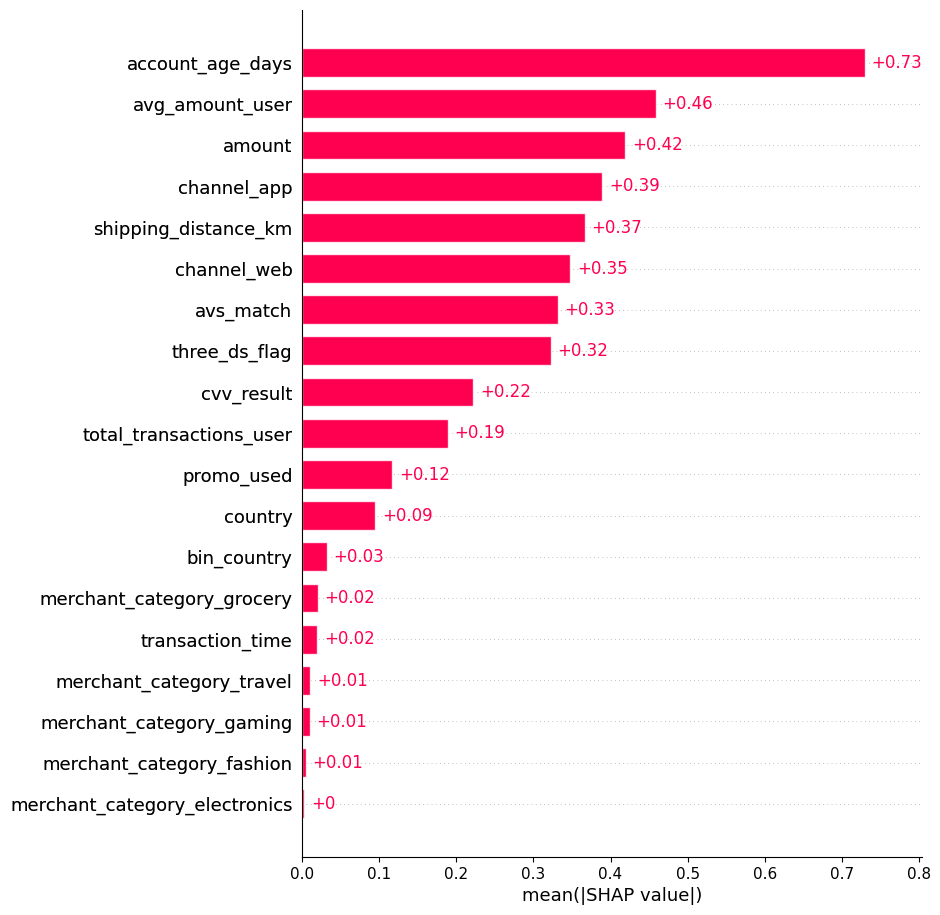

In [30]:
shap.plots.bar(shap_values, max_display=20)
plt.show()
# showing bar with matplotlib

# Shap value Local


Local sample idx: 100 | Predicted goals: 0


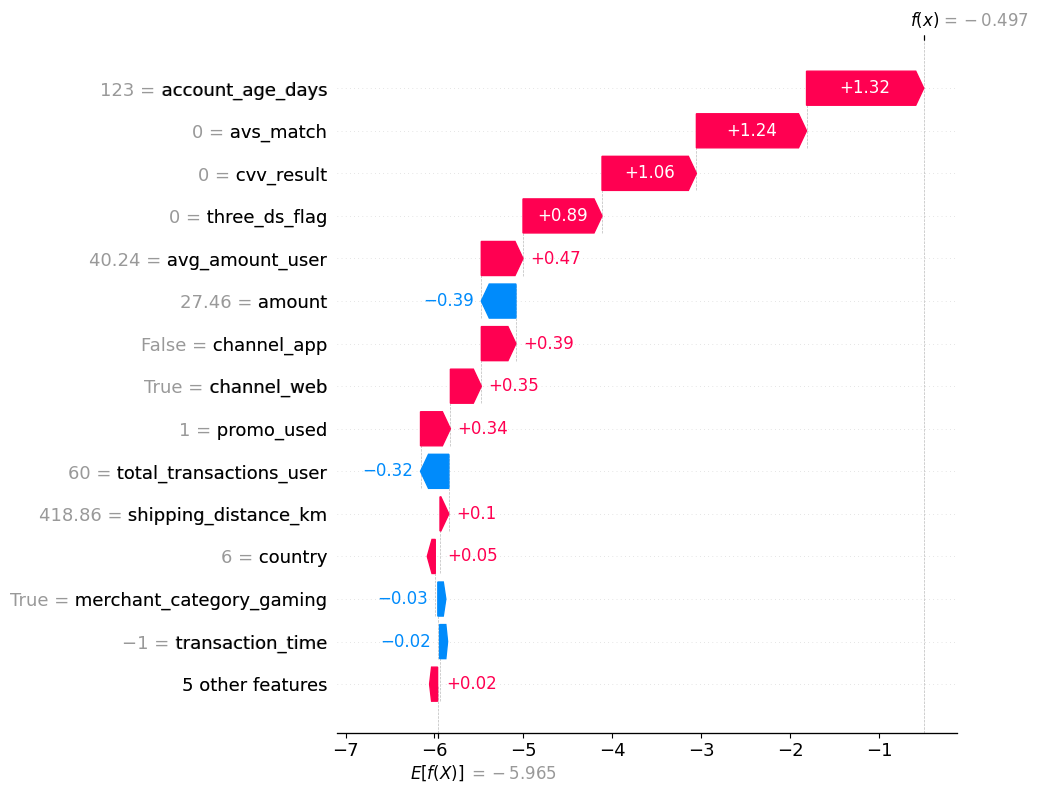

In [31]:
# one sample index
idx = 100
# model prediction 
pred_one = lr.predict(x_sample.iloc[idx:idx+1])[0]
print("\nLocal sample idx:", idx, "| Predicted goals:", pred_one)
# shap waterfall
shap.plots.waterfall(shap_values[idx], max_display=15)
plt.show()

# Training

In [32]:
# training naive bayes and decision tree
nb= GaussianNB()
dt = DecisionTreeClassifier(random_state=42)
nb.fit(x_train_encoded, y_train)
dt.fit(x_train_encoded, y_train)

DecisionTreeClassifier(random_state=42)

In [33]:
#traing support vector machine
svm=LinearSVC(C=1.0)
svm.fit(x_train_encoded, y_train)

LinearSVC()

In [34]:
import os
folder="data"
filename="baseline_trained.csv"
os.makedirs(folder,exist_ok=True)
file_path=os.path.join(folder,filename)
df.to_csv(file_path,index=False)

# Evaluating

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions
y_pred_log = lr.predict(x_test_encoded)
y_pred_tree = rf.predict(x_test_encoded)

# Evaluate Logistic Regression
print("Logistic Regression:")
print("Accuracy :", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall   :", recall_score(y_test, y_pred_log))
print("F1 Score :", f1_score(y_test, y_pred_log))
print("ROC AUC  :", roc_auc_score(y_test, lr.predict_proba(x_test_encoded)[:,1]))

# Evaluate Random Forest
print("RandomForest:")
print("Accuracy :", accuracy_score(y_test, y_pred_tree))
print("Precision:", precision_score(y_test, y_pred_tree))
print("Recall   :", recall_score(y_test, y_pred_tree))
print("F1 Score :", f1_score(y_test, y_pred_tree))
print("ROC AUC  :", roc_auc_score(y_test, rf.predict_proba(x_test_encoded)[:,1]))

Logistic Regression:
Accuracy : 0.9847678473114333
Precision: 0.8447488584474886
Recall   : 0.3830227743271222
F1 Score : 0.5270655270655271
ROC AUC  : 0.9344702942642482
RandomForest:
Accuracy : 0.9914329568394534
Precision: 0.9328021248339974
Recall   : 0.6610201392810089
F1 Score : 0.7737387089667328
ROC AUC  : 0.9677253627936737


In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions
y_pred_log = nb.predict(x_test_encoded)
y_pred_tree = dt.predict(x_test_encoded)

# Evaluate Naivebayes
print("NaiveBayes:")
print("Accuracy :", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall   :", recall_score(y_test, y_pred_log))
print("F1 Score :", f1_score(y_test, y_pred_log))
print("ROC AUC  :", roc_auc_score(y_test, lr.predict_proba(x_test_encoded)[:,1]))

# Evaluate desicionTree
print("Decision Tree:")
print("Accuracy :", accuracy_score(y_test, y_pred_tree))
print("Precision:", precision_score(y_test, y_pred_tree))
print("Recall   :", recall_score(y_test, y_pred_tree))
print("F1 Score :", f1_score(y_test, y_pred_tree))
print("ROC AUC  :", roc_auc_score(y_test, rf.predict_proba(x_test_encoded)[:,1]))

NaiveBayes:
Accuracy : 0.9592252122991708
Precision: 0.2662616528752488
Recall   : 0.4784490871447393
F1 Score : 0.3421265141318977
ROC AUC  : 0.9344702942642482
Decision Tree:
Accuracy : 0.9820567577036654
Precision: 0.5812048192771084
Recall   : 0.6809712027103332
F1 Score : 0.6271450858034321
ROC AUC  : 0.9677253627936737


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions
y_pred_log = nb.predict(x_test_encoded)


# Support Vector Machine
print("SupportVectorMachine:")
print("Accuracy :", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall   :", recall_score(y_test, y_pred_log))
print("F1 Score :", f1_score(y_test, y_pred_log))
print("ROC AUC  :", roc_auc_score(y_test, lr.predict_proba(x_test_encoded)[:,1]))


SupportVectorMachine:
Accuracy : 0.9592252122991708
Precision: 0.2662616528752488
Recall   : 0.4784490871447393
F1 Score : 0.3421265141318977
ROC AUC  : 0.9344702942642482


# Results

In [38]:
from tabulate import tabulate

# Metrics data
data = [
    ["Support Vector machine", 0.9592252122991708,0.2662616528752488,0.4784490871447393,0.3421265141318977,0.9344702942642482],
    ["Decision Tree",0.9820567577036654,0.5812048192771084,0.6809712027103332,0.6271450858034321,0.9677253627936737],
    ["Logistic Regression",0.9847678473114333,0.8447488584474886,0.3830227743271222,0.5270655270655271,0.9344702942642482],
    ["Random ForestClassifier",0.9914329568394534,0.9328021248339974,0.6610201392810089,0.7737387089667328,0.9677253627936737],
    ['NaiveBayes',0.9592252122991708,0.2662616528752488,0.4784490871447393,0.3421265141318977,0.9344702942642482],
]

# Column headers
headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

# Print tabulated table
print(tabulate(data, headers=headers, tablefmt="grid", floatfmt=".3f"))

+-------------------------+------------+-------------+----------+------------+-----------+
| Model                   |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
+=========================+============+=============+==========+============+===========+
| Support Vector machine  |      0.959 |       0.266 |    0.478 |      0.342 |     0.934 |
+-------------------------+------------+-------------+----------+------------+-----------+
| Decision Tree           |      0.982 |       0.581 |    0.681 |      0.627 |     0.968 |
+-------------------------+------------+-------------+----------+------------+-----------+
| Logistic Regression     |      0.985 |       0.845 |    0.383 |      0.527 |     0.934 |
+-------------------------+------------+-------------+----------+------------+-----------+
| Random ForestClassifier |      0.991 |       0.933 |    0.661 |      0.774 |     0.968 |
+-------------------------+------------+-------------+----------+------------+-----------+

# Improved 

In [39]:
df=pd.read_csv('/Users/abduroshyd/Downloads/data/df_row.csv')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   account_age_days         299695 non-null  int64  
 1   total_transactions_user  299695 non-null  int64  
 2   avg_amount_user          299695 non-null  float64
 3   amount                   299695 non-null  float64
 4   country                  299695 non-null  object 
 5   bin_country              299695 non-null  object 
 6   channel                  299695 non-null  object 
 7   merchant_category        299695 non-null  object 
 8   promo_used               299695 non-null  int64  
 9   avs_match                299695 non-null  int64  
 10  cvv_result               299695 non-null  int64  
 11  three_ds_flag            299695 non-null  int64  
 12  transaction_time         299695 non-null  object 
 13  shipping_distance_km     299695 non-null  float64
 14  is_f

In [41]:
df.isnull().sum()

account_age_days           0
total_transactions_user    0
avg_amount_user            0
amount                     0
country                    0
bin_country                0
channel                    0
merchant_category          0
promo_used                 0
avs_match                  0
cvv_result                 0
three_ds_flag              0
transaction_time           0
shipping_distance_km       0
is_fraud                   0
dtype: int64

# Encoding

In [42]:
from sklearn.preprocessing import LabelEncoder

def encodla_train(df, onehot_threshold=5):    
    label_encoders = {}
    onehot_cols = {}

    for col in df.columns:
        if df[col].dtype == 'object':
            if df[col].nunique() <= onehot_threshold:
                onehot_cols[col] = df[col].unique()
            else:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col])
                label_encoders[col] = le

    df = pd.get_dummies(df, columns=onehot_cols.keys(), drop_first=True)

    return df, label_encoders, onehot_cols

In [43]:
def encodla_test(df, label_encoders, onehot_cols, train_columns):
    

    # Label encoding with unseen handling
    for col, le in label_encoders.items():
        df[col] = df[col].apply(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )

    # One-hot encoding
    df = pd.get_dummies(df, columns=onehot_cols.keys(), drop_first=True)

    # Align columns
    df = df.reindex(columns=train_columns, fill_value=0)

    return df

In [44]:
x_train, label_encoders, onehot_cols = encodla_train(x_train)

x_test = encodla_test(
    x_test,
    label_encoders,
    onehot_cols,
    train_columns=x_train.columns)

# Handling missing values with KNN

In [45]:
from sklearn.impute import KNNImputer
import pandas as pd

def knn_impute_train(x_train, n_neighbors=5):
   
  
    x_train = x_train.copy()
    imputer = KNNImputer(n_neighbors=n_neighbors)
   
    x_train_imputed = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)
    return x_train_imputed, imputer
# filling missing values with knn

In [46]:
def knn_impute_test(x_test, imputer):
    x_test = x_test.copy()
    x_test_imputed = pd.DataFrame(
        imputer.transform(x_test),
        columns=x_test.columns,
        index=x_test.index
    )
    return x_test_imputed


In [47]:
x_train_knn, knn_imputer = knn_impute_train(x_train, n_neighbors=5)
x_test_knn = knn_impute_test(x_test, knn_imputer)


In [48]:
from sklearn.preprocessing import MinMaxScaler

def scale_train(df):
    df = df.copy()
    scalers = {}

    for col in df.columns:
        if df[col].dtype != 'object':
            scaler = MinMaxScaler()
            df[col] = scaler.fit_transform(df[[col]])
            scalers[col] = scaler

    return df, scalers

In [49]:
def scale_test(df, scalers):
    df = df.copy()

    for col in df.columns:
        if col in scalers:
            df[col] = scalers[col].transform(df[[col]])

    return df

In [50]:
X_train_scaled, scalers = scale_train(x_train)
X_test_scaled = scale_test(x_test, scalers)

# Scaling

In [51]:
x_train_scaled, scalers = scale_train(x_train_encoded)
x_test_scaled = scale_test(x_test_encoded, scalers)
# scaling function gettting runned

In [52]:
x_train_scaled.head()

,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,channel_app,channel_web,merchant_category_electronics,merchant_category_fashion,merchant_category_gaming,merchant_category_grocery,merchant_category_travel
52459,0.287983,1.00,0.024837,0.008135,0.666667,0.666667,1.0,0.0,0.0,0.0,0.147890,0.071177,1.0,0.0,0.0,0.0,1.0,0.0,0.0
155258,0.782954,0.90,0.024602,0.004029,0.444444,0.333333,0.0,1.0,1.0,1.0,0.112826,0.321713,0.0,1.0,0.0,1.0,0.0,0.0,0.0
296928,0.367390,0.40,0.031532,0.009583,0.222222,0.222222,0.0,1.0,1.0,1.0,0.207243,0.050118,1.0,0.0,0.0,1.0,0.0,0.0,0.0
204506,0.301747,0.75,0.035021,0.017028,0.666667,0.666667,1.0,1.0,1.0,0.0,0.004293,0.076942,0.0,1.0,0.0,0.0,0.0,0.0,1.0
18604,0.106406,0.30,0.050728,0.029232,0.888889,0.888889,0.0,1.0,1.0,1.0,0.577846,0.056584,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [53]:
x_test_scaled.head()

,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,channel_app,channel_web,merchant_category_electronics,merchant_category_fashion,merchant_category_gaming,merchant_category_grocery,merchant_category_travel
182583,0.686077,0.95,0.012995,0.003861,0.000000,0.000000,0.0,1.0,1.0,1.0,-0.000017,0.058209,0.0,1.0,0.0,0.0,0.0,0.0,1.0
106870,0.697724,0.10,0.003777,0.000825,0.111111,0.111111,0.0,1.0,1.0,0.0,-0.000017,0.026493,0.0,1.0,0.0,0.0,0.0,1.0,0.0
225734,0.719958,0.90,0.156402,0.020230,0.555556,0.555556,0.0,0.0,1.0,1.0,-0.000017,0.031916,1.0,0.0,0.0,1.0,0.0,0.0,0.0
229712,0.401800,0.65,0.100454,0.031066,0.666667,0.666667,0.0,1.0,1.0,1.0,-0.000017,0.103752,1.0,0.0,0.0,0.0,0.0,1.0,0.0
13696,0.107464,0.55,0.023307,0.008809,0.222222,0.222222,0.0,1.0,1.0,1.0,-0.000017,0.078572,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [54]:
import os
folder="Data"
filename="improved_preprocessing.csv"
os.makedirs(folder,exist_ok=True)
file_path=os.path.join(folder,filename)
df.to_csv(file_path,index=False)

# Feature engeenering

# Feature creation for x_train

In [55]:

# Transaction amount relative to user's historical average amount
x_train['amount_per_transaction_user'] = (
    x_train['amount'] / x_train['avg_amount_user']
)

# Average number of transactions per day since account creation
# +1 is used to avoid division by zero for new accounts
x_train['transactions_per_day'] = (
    x_train['total_transactions_user'] / (x_train['account_age_days'] + 1)
)

# Flag indicating long-distance shipping transactions (> 100 km)
x_train['is_long_distance_shipping'] = (
    x_train['shipping_distance_km'] > 100
).astype(int)

# User's average amount per transaction
# +1 prevents division by zero when total_transactions_user is 0
x_train['avg_amount_per_transaction'] = (
    x_train['avg_amount_user'] / (x_train['total_transactions_user'] + 1)
)

# Current transaction amount compared to user's average amount
x_train['amount_over_avg'] = (
    x_train['amount'] / x_train['avg_amount_user']
)




In [56]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59939 entries, 52459 to 42950
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   account_age_days             59939 non-null  int64  
 1   total_transactions_user      59939 non-null  int64  
 2   avg_amount_user              59939 non-null  float64
 3   amount                       59939 non-null  float64
 4   country                      59939 non-null  int64  
 5   bin_country                  59939 non-null  int64  
 6   promo_used                   59939 non-null  int64  
 7   avs_match                    59939 non-null  int64  
 8   cvv_result                   59939 non-null  int64  
 9   three_ds_flag                59939 non-null  int64  
 10  transaction_time             59939 non-null  int64  
 11  shipping_distance_km         59939 non-null  float64
 12  channel_web                  59939 non-null  bool   
 13  merchant_category

# Feature creation for x_test

In [57]:

# Transaction amount relative to user's historical average amount
x_test['amount_per_transaction_user'] = (
    x_test['amount'] / x_test['avg_amount_user']
)

# Average number of transactions per day since account creation
# +1 is used to avoid division by zero for new accounts
x_test['transactions_per_day'] = (
    x_test['total_transactions_user'] / (x_test['account_age_days'] + 1)
)

# Flag indicating long-distance shipping transactions (> 100 km)
x_test['is_long_distance_shipping'] = (
    x_test['shipping_distance_km'] > 100
).astype(int)

# User's average amount per transaction
# +1 prevents division by zero when total_transactions_user is 0
x_test['avg_amount_per_transaction'] = (
    x_test['avg_amount_user'] / (x_test['total_transactions_user'] + 1)
)
# Current transaction amount compared to user's average amount
x_test['amount_over_avg'] = (
    x_test['amount'] / x_test['avg_amount_user']
)


In [58]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239756 entries, 182583 to 121958
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   account_age_days             239756 non-null  int64  
 1   total_transactions_user      239756 non-null  int64  
 2   avg_amount_user              239756 non-null  float64
 3   amount                       239756 non-null  float64
 4   country                      239756 non-null  int64  
 5   bin_country                  239756 non-null  int64  
 6   promo_used                   239756 non-null  int64  
 7   avs_match                    239756 non-null  int64  
 8   cvv_result                   239756 non-null  int64  
 9   three_ds_flag                239756 non-null  int64  
 10  transaction_time             239756 non-null  int64  
 11  shipping_distance_km         239756 non-null  float64
 12  channel_web                  239756 non-null  bool   
 13 

# Feature transforming

In [59]:
numeric_cols = x_train.select_dtypes(include=['float64', 'int64']).columns


skewness = x_train[numeric_cols].skew()

# Select features with high skewness (abs > 0.75)
skewed_features = skewness[abs(skewness) > 0.70].index.tolist()
print("Skewed features:", skewed_features)

Skewed features: ['avg_amount_user', 'amount', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag', 'shipping_distance_km', 'amount_per_transaction_user', 'transactions_per_day', 'is_long_distance_shipping', 'avg_amount_per_transaction', 'amount_over_avg']


In [60]:
x_train_transformed = x_train.copy()
x_test_transformed = x_test.copy()

for col in skewed_features:

    if (x_train_transformed[col] >= 0).all():
        x_train_transformed[col] = np.log1p(x_train_transformed[col])
        x_test_transformed[col] = np.log1p(x_test_transformed[col])

In [61]:
x_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59939 entries, 52459 to 42950
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   account_age_days             59939 non-null  int64  
 1   total_transactions_user      59939 non-null  int64  
 2   avg_amount_user              59939 non-null  float64
 3   amount                       59939 non-null  float64
 4   country                      59939 non-null  int64  
 5   bin_country                  59939 non-null  int64  
 6   promo_used                   59939 non-null  float64
 7   avs_match                    59939 non-null  float64
 8   cvv_result                   59939 non-null  float64
 9   three_ds_flag                59939 non-null  float64
 10  transaction_time             59939 non-null  int64  
 11  shipping_distance_km         59939 non-null  float64
 12  channel_web                  59939 non-null  bool   
 13  merchant_category

# Feature selection with linear model

In [62]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd


x_train_tree = x_train_transformed.copy()
x_test_tree = x_test_transformed.copy()


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_tree, y_train)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=x_train_tree.columns)
importances_sorted = importances.sort_values(ascending=False)


top_features_tree = importances_sorted.head(10).index.tolist()
print("Top features for Tree Models:", top_features_tree)


x_train_tree_selected = x_train_tree[top_features_tree]
x_test_tree_selected = x_test_tree[top_features_tree]


Top features for Tree Models: ['shipping_distance_km', 'amount_over_avg', 'amount_per_transaction_user', 'account_age_days', 'amount', 'transactions_per_day', 'avs_match', 'transaction_time', 'avg_amount_user', 'avg_amount_per_transaction']


In [63]:
import os
folder="Data"
filename="improved_engeneered.csv"
os.makedirs(folder,exist_ok=True)
file_path=os.path.join(folder,filename)
df.to_csv(file_path,index=False)

# Training

# Decision tree

In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(x_train_tree_selected, y_train)


y_pred_tree = dtree.predict(x_test_tree_selected)
y_prob_tree = dtree.predict_proba(x_test_tree_selected)[:,1]
# Training ecision tree

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred_tree)
precision = precision_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree)
roc_auc = roc_auc_score(y_test, y_prob_tree)

print("Decision Tree Metrics (after Tree-based feature selection):")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)
print("ROC AUC  :", roc_auc)
# evaluating metrics

Decision Tree Metrics (after Tree-based feature selection):
Accuracy : 0.9771225746175278
Precision: 0.4880122665179816
Recall   : 0.6589497459062676
F1 Score : 0.5607431728998158
ROC AUC  : 0.8216414123678316


# Random forest 

In [66]:

rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_tree_selected, y_train)


y_pred_tree = rf.predict(x_test_tree_selected)
y_prob_tree = rf.predict_proba(x_test_tree_selected)[:,1]

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred_tree)
precision = precision_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree)
roc_auc = roc_auc_score(y_test, y_prob_tree)

print("Random Forest Metrics (after Tree-based feature selection):")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)
print("ROC AUC  :", roc_auc)

Random Forest Metrics (after Tree-based feature selection):
Accuracy : 0.9909366188958775
Precision: 0.9179978700745474
Recall   : 0.6489742141916055
F1 Score : 0.7603925460359466
ROC AUC  : 0.9535807004606782


# Logistic Regression

In [68]:

lr= LogisticRegression(random_state=42)
lr.fit(x_train_tree_selected, y_train)


y_pred_tree = lr.predict(x_test_tree_selected)
y_prob_tree = lr.predict_proba(x_test_tree_selected)[:,1]

/Users/abduroshyd/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred_tree)
precision = precision_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree)
roc_auc = roc_auc_score(y_test, y_prob_tree)

print("Logistic Regression Metrics (after Tree-based feature selection):")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)
print("ROC AUC  :", roc_auc)

Logistic Regression Metrics (after Tree-based feature selection):
Accuracy : 0.9767138257228182
Precision: 0.4567030147530468
Recall   : 0.2680218332392245
F1 Score : 0.3378009726011149
ROC AUC  : 0.8137660698125474


# Naive Bayes

In [70]:

nb= GaussianNB()
nb.fit(x_train_tree_selected, y_train)


y_pred_tree = nb.predict(x_test_tree_selected)
y_prob_tree = nb.predict_proba(x_test_tree_selected)[:,1]

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred_tree)
precision = precision_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree)
roc_auc = roc_auc_score(y_test, y_prob_tree)

print("Naive Bayes Metrics(after Tree-based feature selection):")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)
print("ROC AUC  :", roc_auc)

Naive Bayes Metrics(after Tree-based feature selection):
Accuracy : 0.9832538080381722
Precision: 0.916025641025641
Recall   : 0.2689629211368342
F1 Score : 0.41583005965371744
ROC AUC  : 0.9211384318095154


# Support Vector Machine

In [72]:
from sklearn.svm import SVC

svm = SVC(
    kernel='linear',         
    probability=True,
    class_weight='balanced',
    random_state=42
)

svm.fit(x_train_tree_selected, y_train)

y_pred_tree = svm.predict(x_test_tree_selected)
y_prob_tree = svm.predict_proba(x_test_tree_selected)[:, 1]


In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred_tree)
precision = precision_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree)
roc_auc = roc_auc_score(y_test, y_prob_tree)

print("Naive Bayes Metrics(after Tree-based feature selection):")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)
print("ROC AUC  :", roc_auc)

Naive Bayes Metrics(after Tree-based feature selection):
Accuracy : 0.8351448973122675
Precision: 0.09406739439962031
Recall   : 0.7460944852249201
F1 Score : 0.1670705750953575
ROC AUC  : 0.8664858441032829


# Compare

In [83]:
from tabulate import tabulate

# Metrics data
data = [
    ["Support Vector machine", 0.9592252122991708,0.2662616528752488,0.4784490871447393,0.3421265141318977,0.9344702942642482],
    ["Support Vector machine imp",0.8351448973122675,0.9306739439962031,0.7460944852249201,0.8370705750953575,0.8664858441032829],
    ["Decision Tree",0.9820567577036654,0.5812048192771084,0.6809712027103332,0.6271450858034321,0.9677253627936737],
    ["Decision Tree imp", 0.97712257461752780,0.488012266517981, 0.6589497459062676,0.560743172899815,0.8216414123678316],
    ["Logistic Regression",0.9847678473114333,0.8447488584474886,0.3830227743271222,0.5270655270655271,0.9344702942642482],
    ["Logistic Regression imp",0.9767138257228182,0.4567030147530468,0.2680218332392245,0.3378009726011149,0.8137660698125474],
    ["Random ForestClassifier",0.9914329568394534,0.9328021248339974,0.6610201392810089,0.7737387089667328,0.9677253627936737],
    ["Random ForestClassifier imp",0.9909366188958775,0.9179978700745474,0.6489742141916055,0.7603925460359466,0.9535807004606782],
    ['NaiveBayes',0.9592252122991708,0.2662616528752488,0.4784490871447393,0.3421265141318977,0.9344702942642482],
     ['NaiveBayes imp',0.9832538080381722,0.916025641025641,0.2689629211368342,0.41583005965371744,0.9211384318095154],
]

# Column headers
headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

# Print tabulated table
print(tabulate(data, headers=headers, tablefmt="grid", floatfmt=".3f"))

+-----------------------------+------------+-------------+----------+------------+-----------+
| Model                       |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
+=============================+============+=============+==========+============+===========+
| Support Vector machine      |      0.959 |       0.266 |    0.478 |      0.342 |     0.934 |
+-----------------------------+------------+-------------+----------+------------+-----------+
| Support Vector machine imp  |      0.835 |       0.931 |    0.746 |      0.837 |     0.866 |
+-----------------------------+------------+-------------+----------+------------+-----------+
| Decision Tree               |      0.982 |       0.581 |    0.681 |      0.627 |     0.968 |
+-----------------------------+------------+-------------+----------+------------+-----------+
| Decision Tree imp           |      0.977 |       0.488 |    0.659 |      0.561 |     0.822 |
+-----------------------------+------------+------

In [ ]:
# the improved model show that the most increased algorithm is svm
# accuracy score of svm increased  more then 10% from 83% to 95%
# precision of svm increased 70% from 25% to 93%
# recall of svm increased nearly 30 % from 47% to 74%
# f1 of svmscore increasd nerly 50 % from 34% to 83% 
# the highest accuracy score is Random forest classifier with 91%
# the highest precision is svm with 93%
# the highest recall is  svm with 74%

# Load  best model

In [ ]:

best_model = joblib.dump(svm,"best_model_svm.joblib")